In [2]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

from sklearn.decomposition import PCA

2024-09-04 18:38:56.931068: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 18:38:56.973873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]

def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

l = 0.01
u = 1-0.01

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)

save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240812/'

pc1_grid = np.linspace(pc1_l, pc1_u, 50)
pc2_grid = np.linspace(pc2_l, pc2_u, 50)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'




In [5]:
templates_flatten = metastr_from_pca

NameError: name 'metastr_from_pca' is not defined

In [3]:
def calculate_variance_sample(dmap_list, dmap_ref, num_probes):
    variance_list = [num_probes**-2 * np.linalg.norm(x - dmap_ref)**2 for x in dmap_list]
    return np.mean(variance_list)

In [4]:
calculate_variance_sample(cnc_maps_interp, templates_flatten[2].reshape(80, 80), 80) * 80**2

NameError: name 'templates_flatten' is not defined

In [ ]:
np.logspace(6, 10, 5)

array([1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])

In [ ]:
sns.jointplot(x='PC1', y='PC2', data=all_df, marker='.', hue='label', alpha=0.75)
plt.scatter(pc1_grid_flat, pc2_grid_flat, marker='x', color='green', s=50, alpha=0.25, label='metastructures')
plt.legend()
# plt.savefig(save_dir + 'pca_2d_with_metastructure.png', dpi=300, bbox_inches='tight')

In [25]:
# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)
metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])

In [24]:
pc1_pc2_df

,PC1,PC2,label
0,-24851.334286,-11871.642447,metastructures
1,-23995.752543,-11871.642447,metastructures
2,-23140.170799,-11871.642447,metastructures
3,-22284.589055,-11871.642447,metastructures
4,-21429.007311,-11871.642447,metastructures
...,...,...,...
2495,13649.844185,12517.536162,metastructures
2496,14505.425929,12517.536162,metastructures
2497,15361.007673,12517.536162,metastructures
2498,16216.589416,12517.536162,metastructures


In [ ]:
templates_flatten = metastr_from_pca
    
measurement_error_esc = [calculate_variance_sample(esc_maps_interp, x.reshape(80, 80), 80)**0.5 for x in templates_flatten]
measurement_error_cnc = [calculate_variance_sample(cnc_maps_interp, x.reshape(80, 80), 80)**0.5 for x in templates_flatten]
# measurement_error_all = [calculate_variance_sample(all_maps_interp, x.reshape(80, 80), 80)**0.5 for x in templates_flatten]

KeyboardInterrupt: 

In [ ]:
# This is very large so it is slow to plot 
# Plot 50 x 50 grid of metastructures based on PC1 and PC2 

# fig, axs = plt.subplots(50,50, figsize=(20, 20))
# for i in range(2500):
#     ax=axs[i%50, i//50]
#     metastr = metastr_from_pca[i]
#     metastr = metastr.reshape((80, 80))
#     ax.imshow(metastr, cmap='Reds_r', vmax=700)
#     # ax.set_title(f'M{i}')
#     # axs[i//10, i%10].axis('off')
#     # if ax is in the first col, add a y label
#     if i // 50 == 0:
#         ax.set_ylabel(i)
#     # if ax is in the last row, add a x label
#     if i % 50 == 49:
#         ax.set_xlabel(i//50)
        
#     # Remove ticks by setting them to an empty list
#     ax.set_xticks([])
#     ax.set_yticks([])
    
# plt.savefig(save_dir + 'metastructure_maps_sorted_by_pca_2500.png', dpi=300, bbox_inches='tight')

In [4]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

In [32]:
pc1_unique

array([-24851.33428648, -23995.75254267, -23140.17079886, -22284.58905505,
       -21429.00731124, -20573.42556744, -19717.84382363, -18862.26207982,
       -18006.68033601, -17151.0985922 , -16295.51684839, -15439.93510458,
       -14584.35336078, -13728.77161697, -12873.18987316, -12017.60812935,
       -11162.02638554, -10306.44464173,  -9450.86289792,  -8595.28115411,
        -7739.69941031,  -6884.1176665 ,  -6028.53592269,  -5172.95417888,
        -4317.37243507,  -3461.79069126,  -2606.20894745,  -1750.62720365,
         -895.04545984,    -39.46371603,    816.11802778,   1671.69977159,
         2527.2815154 ,   3382.86325921,   4238.44500302,   5094.02674682,
         5949.60849063,   6805.19023444,   7660.77197825,   8516.35372206,
         9371.93546587,  10227.51720968,  11083.09895348,  11938.68069729,
        12794.2624411 ,  13649.84418491,  14505.42592872,  15361.00767253,
        16216.58941634,  17072.17116015])

In [26]:
# This is very important because metastructure order is listed by how its loaded

pc1_unique = np.unique(pc1_pc2_df['PC1'])
pc2_unique = np.unique(pc1_pc2_df['PC2'])

pc1_marginal_index = [np.where(pc1_pc2_df['PC1'] == x)[0] for x in pc1_unique]
pc2_marginal_index = [np.where(pc1_pc2_df['PC2'] == x)[0] for x in pc2_unique]

In [27]:
pc1_marginal_index

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]),
 array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 19

In [6]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240812_WeightMCMC_PCA_metastructures_3'

In [7]:
stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')
stan_directory_all = os.path.join(common_dir, 'all/stan_output')


In [16]:
esc_log_weights = load_weights(stan_directory_esc, 2500)
cnc_log_weights = load_weights(stan_directory_cnc, 2500)
# all_log_weights = load_weights(stan_directory_all, 2500)

['20240715_WeightOptimization-20240812175231_1.csv', '20240715_WeightOptimization-20240812175231_2.csv', '20240715_WeightOptimization-20240812175231_3.csv', '20240715_WeightOptimization-20240812175231_4.csv']
['20240715_WeightOptimization-20240812180729_1.csv', '20240715_WeightOptimization-20240812180729_2.csv', '20240715_WeightOptimization-20240812180729_3.csv', '20240715_WeightOptimization-20240812180729_4.csv']


In [18]:
esc_log_weights[0, :]

array([[ -8.3641948,  -9.4459848,  -7.5100598, ...,  -8.6906762,
         -7.9571845,  -8.8329518],
       [ -6.8162933,  -6.737157 ,  -9.1111657, ...,  -8.3484952,
         -8.489914 ,  -7.8085571],
       [ -7.8207506, -10.856555 ,  -9.8434504, ...,  -8.8115303,
         -9.2116386,  -7.9038074],
       ...,
       [ -9.6694866,  -8.6803585,  -8.1591825, ...,  -8.3341621,
         -8.718165 ,  -7.2211653],
       [ -6.1782222,  -9.6520061,  -7.5947223, ...,  -9.9885691,
         -9.8592263, -11.069221 ],
       [ -8.9129566, -11.402486 ,  -9.1110584, ...,  -8.7098995,
         -9.3287949,  -8.4627644]])

In [9]:
esc_weights_all = np.exp(np.array(esc_log_weights))
cnc_weights_all = np.exp(np.array(cnc_log_weights))

esc_weights_all = esc_weights_all.reshape(-1, 2500)
cnc_weights_all = cnc_weights_all.reshape(-1, 2500)

esc_entropy_all = np.array([scipy.stats.entropy(x) for x in esc_weights_all])
cnc_entropy_all = np.array([scipy.stats.entropy(x) for x in cnc_weights_all])

# Put these data in dataframe 
esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
cnc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'NPC'})

all_entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df], axis=0)

In [20]:
esc_entropy_all[:5]

array([7.31809043, 7.33540839, 7.31562822, 7.32397892, 7.31981325])

In [14]:
len(pc1_marginal_index)

50

In [28]:
pc1_marginal_prob = []
pc2_marginal_prob = []
for i in range(4000):
    pc1_list = []
    pc2_list = []
    for j in range(50):
        pc1_list.append(np.sum(esc_weights_all[i, pc1_marginal_index[j]]))
        pc2_list.append(np.sum(esc_weights_all[i, pc2_marginal_index[j]]))
    pc1_marginal_prob.append(pc1_list)
    pc2_marginal_prob.append(pc2_list)

In [29]:
pc1_marginal_prob = np.array(pc1_marginal_prob)
pc2_marginal_prob = np.array(pc2_marginal_prob)

In [30]:
pc1_marginal_prob[0]

array([0.01810084, 0.01252799, 0.01223429, 0.0159862 , 0.01637597,
       0.01502912, 0.01460734, 0.01636641, 0.01720421, 0.01711511,
       0.0157504 , 0.01679749, 0.01406708, 0.02027406, 0.01746354,
       0.02138289, 0.01890602, 0.01974762, 0.01928364, 0.01923768,
       0.03353407, 0.02226878, 0.02620146, 0.02900828, 0.02765665,
       0.02678973, 0.02722562, 0.03042857, 0.0285826 , 0.03126118,
       0.03251641, 0.02966775, 0.0333557 , 0.02610704, 0.02379468,
       0.02450027, 0.01574107, 0.01963098, 0.01641777, 0.01740206,
       0.01344293, 0.01294188, 0.01631014, 0.01070554, 0.01313941,
       0.01333098, 0.01516186, 0.01534243, 0.01244098, 0.01663529])

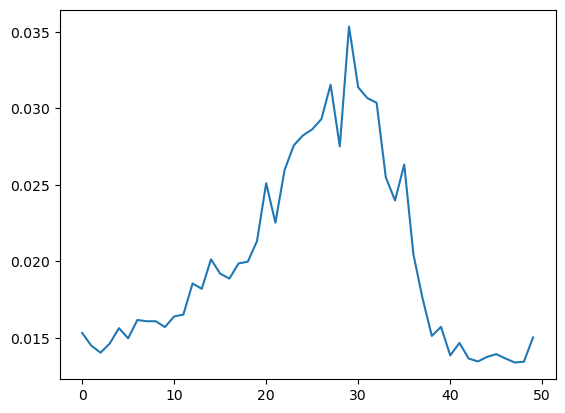

In [31]:
plt.plot(np.mean(pc1_marginal_prob, axis=0))

In [11]:
esc_weights = np.mean(np.exp(np.array(esc_log_weights)), axis=(0, 1))
cnc_weights = np.mean(np.exp(np.array(cnc_log_weights)), axis=(0, 1))

# Put weights in a DataFrame
esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values,  
                               'weight': esc_weights})
esc_weights_df['label'] = 'ESC'
cnc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values, 
                               'weight': cnc_weights})
cnc_weights_df['label'] = 'CNC'

In [ ]:
import matplotlib

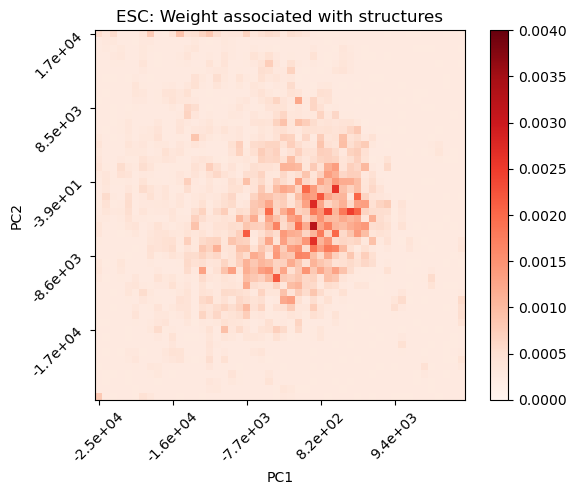

In [17]:
plt.imshow(esc_weights_df['weight'].values.reshape(50, 50).T,
           cmap='Reds', vmin=0, vmax=0.004)
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC: Weight associated with structures')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'esc_weights_50x50.png'), dpi=300, bbox_inches='tight')

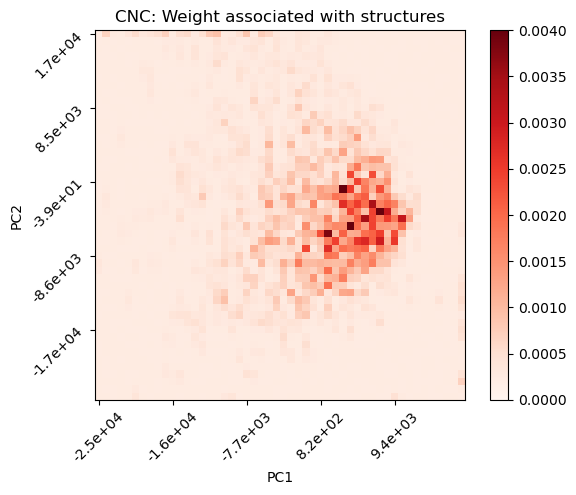

In [18]:
plt.imshow(cnc_weights_df['weight'].values.reshape(50, 50).T,
           cmap='Reds', vmin=0, vmax=0.004)
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC: Weight associated with structures')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'cnc_weights_50x50.png'), dpi=300, bbox_inches='tight')

In [19]:
esc_weight_table = esc_weights_df['weight'].values.reshape(50, 50).T
cnc_weight_table = cnc_weights_df['weight'].values.reshape(50, 50).T

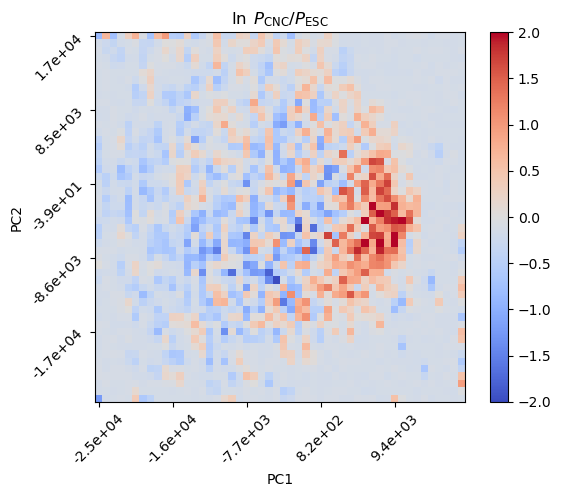

In [24]:
plt.imshow(np.log(cnc_weight_table / esc_weight_table), cmap='coolwarm', vmin=-2, vmax=2)
plt.colorbar()
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{CNC}/P_\mathrm{ESC}$')
plt.savefig(os.path.join(save_dir, 'prob_ratio_50x50.png'), dpi=300, bbox_inches='tight')

/tmp/ipykernel_1330389/264283758.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.round(cnc_weights_df['PC1'].unique(), 0), rotation=45)
/tmp/ipykernel_1330389/264283758.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=np.round(cnc_weights_df['PC2'].unique(), 0))


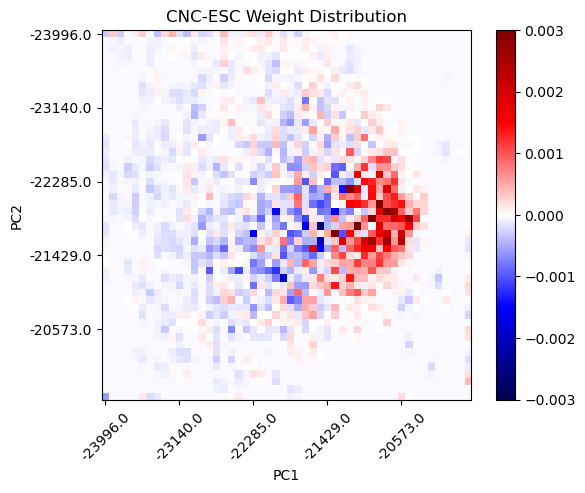

In [ ]:
norm = matplotlib.colors.Normalize(vmin=-0.003, vmax=0.003)
fig, ax = plt.subplots()
contour = ax.imshow( 
            cnc_weight_table - esc_weight_table,
            norm=norm,cmap='seismic')
fig.colorbar(contour, ax=ax)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('CNC-ESC Weight Distribution')
ax.set_xticklabels(labels=np.round(cnc_weights_df['PC1'].unique(), 0), rotation=45)
ax.set_yticklabels(labels=np.round(cnc_weights_df['PC2'].unique(), 0))
fig.savefig(os.path.join(save_dir, 'cnc_esc_weight_diff_true.png'), dpi=300, bbox_inches='tight')

In [27]:
diff_table = np.log(cnc_weight_table/ esc_weight_table)


In [28]:
# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[-10:]

# Convert the flattened indices back to 2D indices
top_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
top_10_indices = list(zip(top_10_indices[0], top_10_indices[1]))

In [29]:
metastr_dict = {}
for i in range(2500):
    idx = (i%50, i//50)
    metastr = metastr_from_pca[i]
    metastr = metastr.reshape((80, 80))
    metastr_dict[idx] = metastr

(36, 28)

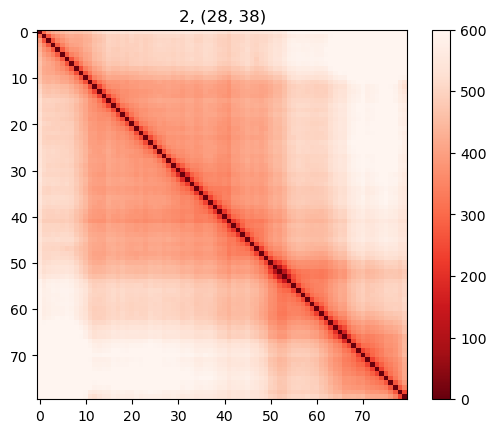

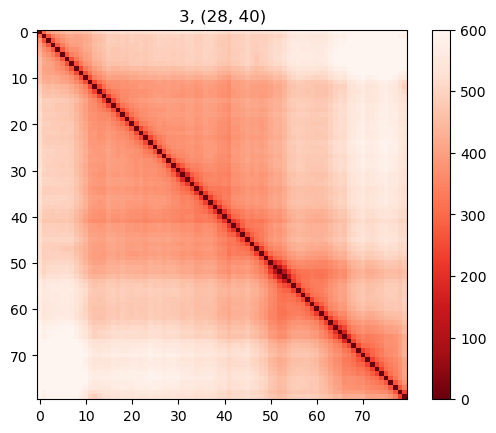

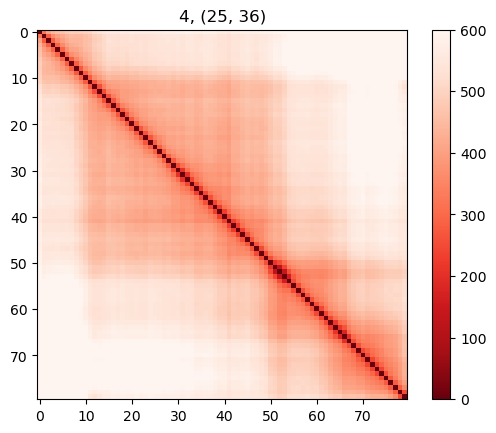

In [30]:
for i in range(1, 4):
    plt.imshow(metastr_dict[top_10_indices[-i]], cmap='Reds_r', vmax=600)
    plt.colorbar()
    plt.title('{}, {}'.format(i+1, top_10_indices[-i]))
    plt.savefig(os.path.join(save_dir, 'top_{}_metastructure.png'.format(i+1)), dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[:10]

# Convert the flattened indices back to 2D indices
bottom_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
bottom_10_indices = list(zip(bottom_10_indices[0], bottom_10_indices[1]))

In [ ]:
(np.array(diff_table))[bottom_10_indices[2]]

-0.0018879709256608935

In [ ]:
bottom_10_indices

[(26, 29),
 (28, 29),
 (33, 24),
 (27, 20),
 (26, 27),
 (24, 31),
 (29, 29),
 (24, 23),
 (21, 32),
 (32, 23)]

In [ ]:
top_10_indices

[(28, 36),
 (24, 39),
 (28, 38),
 (25, 41),
 (23, 37),
 (25, 36),
 (27, 31),
 (26, 34),
 (21, 33),
 (24, 38)]

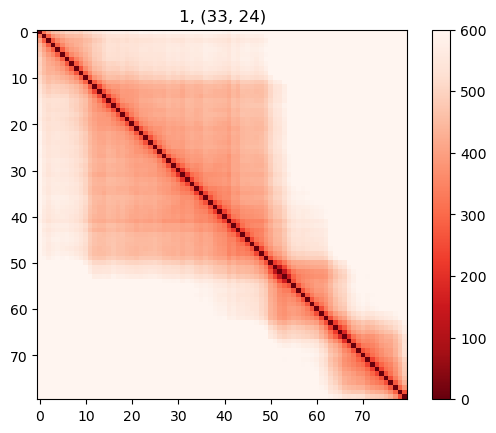

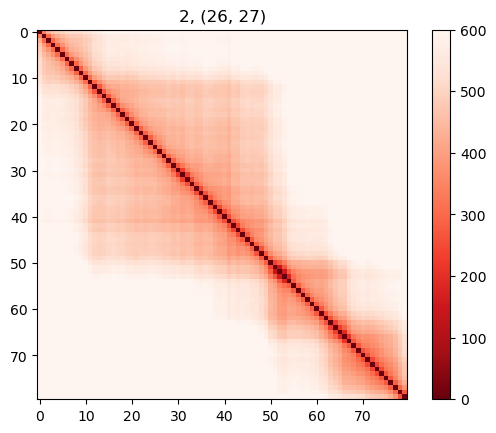

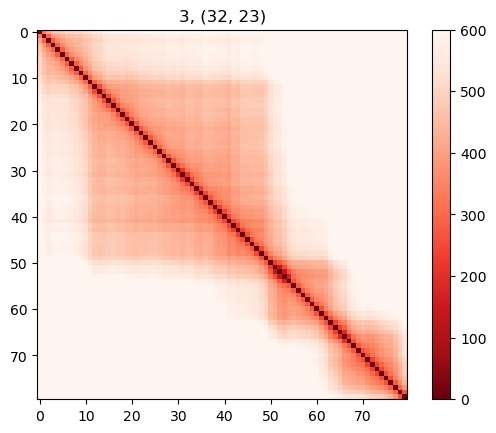

In [32]:
for i in range(3):
    plt.imshow(metastr_dict[bottom_10_indices[i]], cmap='Reds_r', vmax=600)
    plt.colorbar()
    plt.title('{}, {}'.format(i+1, bottom_10_indices[i]))
    plt.savefig(os.path.join(save_dir, 'bottom_{}_metastructure.png'.format(i+1)), dpi=300, bbox_inches='tight')
    plt.show()

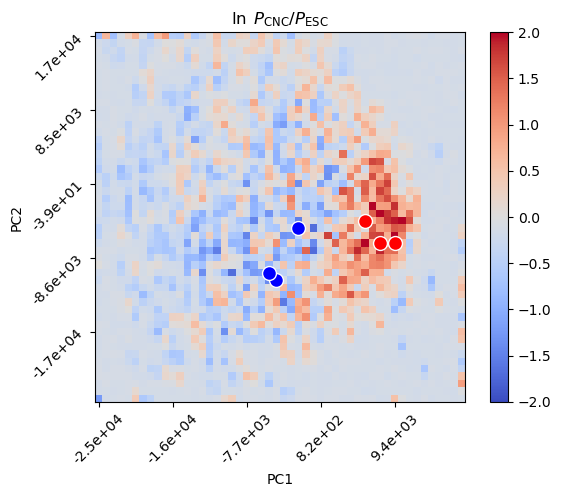

In [35]:
plt.imshow(np.log(cnc_weight_table / esc_weight_table), cmap='coolwarm', vmin=-2, vmax=2)
plt.colorbar()
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{CNC}/P_\mathrm{ESC}$')
plt.savefig(os.path.join(save_dir, 'prob_ratio_50x50.png'), dpi=300, bbox_inches='tight')

# Annotate the top 3 highest values
for i in range(1, 4):
    plt.scatter(top_10_indices[-i][1], top_10_indices[-i][0], color='red', s=100, edgecolor='white')
    # plt.text(top_10_indices[-i][0], top_3_coords[-i][1], f'{data[top_3_coords[0][i], top_3_coords[1][i]]:.2f}', 
    #          color='white', ha='center', va='center', fontsize=9, fontweight='bold')
    
for i in range(3):
    plt.scatter(bottom_10_indices[i][1], bottom_10_indices[i][0], color='blue', s=100, edgecolor='white')
    
plt.savefig(os.path.join(save_dir, 'cnc_esc_prob_ratio_annotate_50x50.png'), dpi=300, bbox_inches='tight')


In [33]:
blank_weight = np.zeros((50, 50))
for i in range(10):
    blank_weight[top_10_indices[i]] = i+1
    blank_weight[bottom_10_indices[i]] = -10+i

Text(0.5, 1.0, 'Max and Min from Different Weight Distributions')

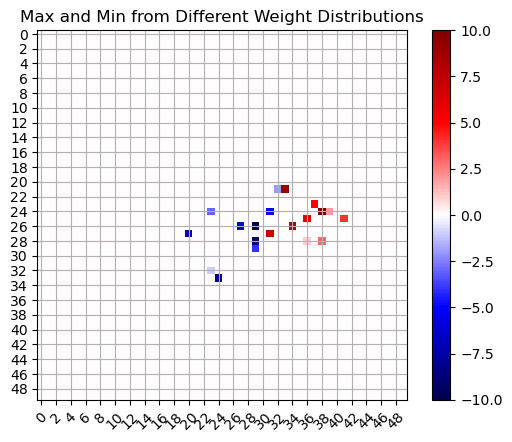

In [35]:
plt.imshow(blank_weight, cmap='seismic', vmin=-10, vmax=10)
plt.colorbar()
plt.grid(True)
plt.xticks(np.arange(0, 50, 2))
plt.yticks(np.arange(0, 50, 2))
plt.xticks(rotation=45) 
plt.title('Max and Min from Different Weight Distributions')

In [ ]:
# Weighted average of enriched metastructures 